In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Principal Author: Mark R. Yoder, Ph.D.
- Email: 
    - mark.yoder@gmail.com
    - myoder96@stanford.edu


### A Short (and incomplete) Tutorial of the Python NetCDF/NCL Tutorial
- After some soul searching and consternation, NOAA is adopting Python as its official scripting language.
- The beloved (or accursed) NCL will be left to history
- Sort of. At this time, the Python interface appears to principally be a wrapper around NCL, so that Ngl and Nio are libraries for writing NCL in Python (aka, Python_object.ncl_command() ), so everybody wins.
- Here, we show one or more quick, simple examples of reading and writing data to/from files, using the Python-NCL interface.

### Overview of NCL Libraries [Nio (pynio), Ngl (pyngl)] , etc.
- If we are using NCL, as a command-line language, we typicall install it, doing something like:
    - conda create env -n ncl_stable -c conda-forge ncl
        - which creates the environment named *ncl_stable*, and then installs the library *ncl* from the channel *conda-forge*
        - This does **not** (I don't think) install the Python hooks. The good news there is that (I don't think) we need *ncl* to use the Python libraries
- NCL is accessed in Python via the PyNIO (IO ops) and PyNGL (graphing) libraries. They can be installed *without ncl*, like:
    - \$ conda create --name pynio_env --channel conda-forge pynio pyngl
    - or, if we don't want/need to create a whole new environment,
    - \$ conda install pynio
    - \$ conda install pyngl
- This is nominally advantageous, because the pynio and pygl installation should be smaller than the full ncl installation (though it might not be), and it is very likely far less contentious with other libraries (ncl will likely require a dedicated environment)
- Some references:
    - PyNIO and PyNGL general: https://www.pyngl.ucar.edu/Examples/index.shtml
    - PyNIO reff: https://www.pyngl.ucar.edu/Nio.shtml
    - GitHub pynio: https://github.com/NCAR/pynio
    - GitHub pyngl: https://github.com/NCAR/pyngl
#### Some decent references:
- https://unidata.github.io/netcdf4-python/netCDF4/index.html
#### Some comments:
- I wrestled a while with an error importing Ngl; something about the *libgforgran3* library not being availablel.
- It wasn't. One way or another (mabe because of a recent conda update), it was installing libgfortran4.x.x into that environment. Nio was fine with that, but Ngl would not have it. 
- I solved it via: \$ conda install libgfortran=3
- Note this can be added into the environment create (if you are making an enviornment), but doind so may not give these libraries the option to evolve (with developers' assistance) to use the newer libfortran.

### NetCDF libraries (netcdf4):
- Nio can handle a variety of data formats
- In this example, we use a NetCDF format.
- This begs the question, should we be using Nio or netCDF4 to open and handle the file?
- This nominally really is a question. My guess at this time is that the Nio object may be better, or required, to use Ngl, but if we're not explicitly using NCL, netCDF4 might be a better choice.
- We'll demo neCDF4 in this notebook, but for some installations of Python, this might be a problem (pynio and pyngl might (need to) be installed under different environments).


In [29]:
#
import pylab as plt
import numpy
import scipy
import scipy.constants
#
import os,sys
#import pathlib
import itertools

import getpass
import subprocess
import contextlib

#### NCL Version:

In [30]:
# NCL stuff:
#import Ngl
import Nio
#
try:
    import Ngl
except Exception as e:
    # it seems a possibly common problem is a libgfortran mismatch.
    # when I set up an environment with Nio and Ngl (currently on a Mac OSX system),
    #. it installs libgfortran.4.x.x, which is fine by Nio, but Ngl is specifically 
    #. looking for a libgfortran.3.x.x. not sure, at this time, if this is an oversite
    #. in the indexing/configuration, or if Ngl really needs v3.x. explicitly installing,
    #. or creating the environment, wiht libgfortran=3 seems to help it work...
    #
    print('*** Warning: import Ngl failed with: {}'. format (e))

def file_report(fin):
    # a simple script to print some information about the provided file (-handle)
    #
    dims = fin.dimensions.values()
    dimnames = fin.dimensions.keys()
    #
    varnames_all = fin.variables.keys()
    varnames = [s for s in varnames_all if not s in dimnames]
    #
    print('** dims: ', list(zip(dimnames, dims)))
    #
    print('** varnames_all: ', varnames_all)
    print('** varnames: ', varnames)
    #

    print('type(fin.dimensions): ', type(fin.dimensions) )
    #
    return None

### Mount network resource (sshfs), if we are working locally from a remote data set
- This will be provided for instructinal purposes, but we won't use it in these examples.
- Clearly, this example is written with reference to a specific HPC system -- the Stanford Earth Mazama cluster.
- This only if we want to pull down a (small) subset of data -- to our local machine, from a remote host
- use subprocess() to mount the remote FS via sshfs
- Note we do * **not** * write our passwords in code, pull it from a (n unencrypted) data file, etc. In fact, in this script, we don't even write it to a variable
    - Note that something like *my_pwd = getpass.getpass()* will populate my_pwd with a clear text (not encrypted) copy of whatever you type into the prompt, so even this is not recommended.
    - If you must store a password, Python has tons of good, super easy to use, encryption libraries. Somewhere, I probably have sample code that I would be happy to share.
- Typically, if you are working on managed resources (aka, your NFS will probably be mounted)

### Create some data (that look sort of like atmospheric modeling)

In [31]:
#### output_file_path = 'pretend_data.nc'
my_lats = numpy.linspace(-90., 90, 10)
my_lons = numpy.linspace(-180., 180., 20)
my_elevs = numpy.arange(0, 10)*1000.
n_timesteps=100
my_time_steps = numpy.arange(0., n_timesteps)
#
if os.path.isfile(output_file_path):
    os.system('rm {}'.format(output_file_path))
#
# do we need to delete the file?
with contextlib.closing(Nio.open_file(output_file_path, 'c')) as fout:
    #
    # defne dimensions (note we can use the scritped syntax below):
    fout.create_dimension('time', n_timesteps)
    fout.create_dimension('alt', len(my_elevs))
    fout.create_dimension('lat', len(my_lats))
    fout.create_dimension('lon', len(my_lons))
    #
    # assign values to dimension variables (using list scripted syntax)
    #fout.create_variable('time', 'f', ('time',) )
    # NOTE: variables types are 'f' for short(er) float; 'd' for a double, or long float.
#     fout.create_variable('lat', 'd', ('lat',))
#     fout.create_variable('lon', 'd', ('lon',))
#     fout.create_variable('alt', 'd', ('alt',))
#     fout.create_variable('time', 'd', ('time',))
#     #
#     # this breaks (something about types not matching)
#     #fout.variables['lat'].assign_value(my_lats[:])
#     # these work, but the object does not retain the values.
#     fout.variables['lat'][:] = my_lats
#     fout.variables['lon'][:] = my_lons
#     fout.variables['alt'][:] = my_elevs
#     fout.variables['time'][:] = my_time_steps
    
    for s,x in zip(['time', 'alt', 'lat', 'lon'], [my_time_steps, my_elevs, my_lats, my_lons]):
        #print('** {} / {}'.format(s, fout.dimensions[s]))
        #
        # note: 1) we provide the dimension of the variable as a tuple
        #  2) 'f' is a small float, 'd' is a big float ("double"); trying to assign 'd' values
        #.  into a type 'f' variable may throw an error (as it does in this case)
        #fout.create_variable(s, 'f', (s,) )
        fout.create_variable(s, 'd', (s,) )
        fout.variables[s][:]=x
        #print('** DEBUG: var[{}]: {}'.format(s, fout.variables[s]))
        print('** ** DEBUG: shape: ', numpy.shape(fout.variables[s]))
    #
    # Instantiate a data variable.
    # outf.create_variable('t','f',('time','lat','lon'))
    fout.create_variable('U','d',('time', 'alt', 'lat','lon'))
    setattr(fout.variables['U'], 'standard_name', 'pressure')
    setattr(fout.variables['U'], 'units', 'kPa')
    #
    print('** DEBUG: time: ', min(fout.variables['time']), max(fout.variables['time']))
    print('** DEBUG: lat: ', min(fout.variables['lat']), max(fout.variables['lat']))
    # variable assignment:
    # This syntax is required for scaler, non-indexed values (or so I have read):
    # fout.variables['u'].assign_value(udum)        # this works if dimensions align
    #. we can also use it for arrays, but only if we are assigning the whole value -- in other words, the 
    #. dimensinos must match. (this works if dim(udum)==dim(fout)). I assume the exception is if the output
    #. dimension is undefined, all other dimensions must match.
    #
    # For batched assignment, we can use:
    # fout.variables['u'][0:len(udum)] = udum      # use this for partial assignment (note, i think this does allow 
    #                                            # (aka, will expand) for overflow -- [k,j] > len(fout.variable) )
    #  if the dimenstions match, we can use this syntax without "slice" indices.
    #
    # and we might want to close the file here:
    print('file created: ')
    print(file_report(fout))
    #fout.close()
#

** ** DEBUG: shape:  (100,)
** ** DEBUG: shape:  (10,)
** ** DEBUG: shape:  (10,)
** ** DEBUG: shape:  (20,)
** DEBUG: time:  0.0 99.0
** DEBUG: lat:  -90.0 90.0
file created: 
** dims:  [('time', 100), ('alt', 10), ('lat', 10), ('lon', 20)]
** varnames_all:  dict_keys(['time', 'alt', 'lat', 'lon', 'U'])
** varnames:  ['U']
type(fin.dimensions):  <class 'dict'>
None


In [32]:
# Assign some values:
# NOTE: we could have done this during the 'create' phase, but we want to demonstrate 
#. opening and closing.
with contextlib.closing(Nio.open_file(output_file_path, 'r+')) as fout:
    #
    # if we just want to make our code work, we can do this:
    #fout.variables['U'] = numpy.random.random(size=list(fout.dimensions.values()))
    ##
    ## and even slightly differentiate the layers:
    ## add the index value to each altitude layer, so each layer is ~ 0+u, 1+u, 2+u, ...
    ##. (where u is a random number).
    #for k in range(0, fout.dimensions['alt']):
    #    fout.variables['U'][:,k,:,:] += k
    #
    # A more interesting example, fromm which we can make some pretty pictures:
    # compute some periodic constants:
    T_x = scipy.constants.pi/(max(fout.variables['lon']) - min(fout.variables['lon']))
    T_y = scipy.constants.pi/(max(fout.variables['lat']) - min(fout.variables['lat']))
    T_t = 2.*scipy.constants.pi/(max(fout.variables['time']) - min(fout.variables['time']))
    N_pi = numpy.arange(1, fout.dimensions['alt']+1,1)
    #
    #print('** DEBUG Ts: ', T_x, T_y, N_pi)
    #print('** DEBUG: T_t: ', min(fout.variables['time']) , max(fout.variables['time']))
    #print('** DEBUG: time2: ', min(fout.variables['time']), max(fout.variables['time']))
    #
    # Populate the array:
    # For 2D arrays, we can use numpy.meshgrid(Xs, Ys) to get a dense n_x x n_y array, but
    #. I don't think there is a 2D abstraction. We want to avoid a fully nested loop, unless
    #. memory is a restriction.
    #
    XX, YY = numpy.array(numpy.meshgrid( fout.variables['lon'], fout.variables['lat']) )
    XX *= T_x
    YY *= T_y
    #
    # there's a faster, numpy way to do this (rebroadcast as cartesian dimensions), but I'm just going to
    #. get it done. (can you meshgrid() nested objects?
    #
    #print('*** shape:', numpy.shape(fout.variables['U']))
    #
    # we can probably do this more efficiently using numpy.outer(X,Y); we can nest numpy.outer()
    #. calls, and then reshpae(), xx = numpy.outer(X, numpy.outer(Y,Z)).reshape(len(X), len(Y), len(Z)))
    #
    #
    for (k_t, phi),k_z in itertools.product(enumerate(fout.variables['time']*T_t), N_pi):
        #
        #print('** ** ', k_t, phi, k_z)
        #zs = numpy.cos(k_z*XX + phi)*numpy.sin(k_z*YY + phi)
        #print('** DEBUG: zs: ', numpy.shape(zs))
        fout.variables['U'][k_t, k_z, :,:] = numpy.cos(k_z*XX + phi)*numpy.sin(k_z*YY + phi)
        
        #if k_z>5: break
#


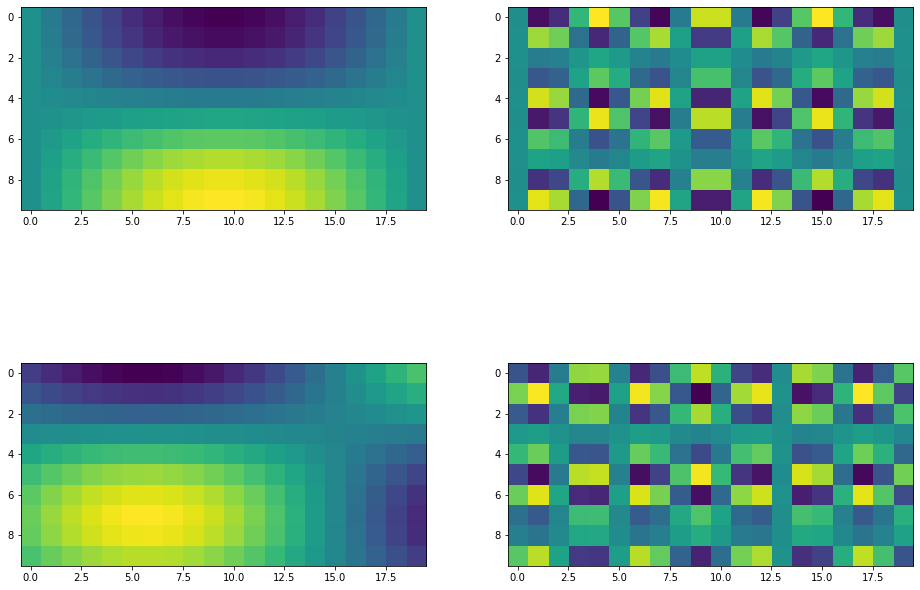

In [33]:
fg = plt.figure(figsize=(16,12))
axes = [plt.subplot(2,2,k+1) for k in range(4)]
#
with contextlib.closing(Nio.open_file(output_file_path, 'r')) as fin:
    #
    axes[0].imshow(fin.variables['U'][0,1,:,:])
    axes[1].imshow(fin.variables['U'][0,7,:,:])
    axes[2].imshow(fin.variables['U'][10,1,:,:])
    axes[3].imshow(fin.variables['U'][10,7,:,:])

In [34]:
X = numpy.outer(numpy.arange(5), numpy.arange(4))
print('** ', X)
XZ = numpy.outer(numpy.arange(3), X).reshape((3,5,4))
print('*** ', XZ)
print('shape: ', XZ.shape)
#
# XX,YY = numpy.array(numpy.meshgrid(numpy.arange(5), numpy.arange(10)))
# print('** ', XX.shape)
# print('** ', XX)
# #print('** ', YY)

# print('** ** \n', numpy.outer(numpy.ones(2),XX) )

# #with contextlib.closing(Nio.open_file(output_file_path, 'r+')) as fout:
# #    print('dims: ', fout.dimensions)



# #f = Nio.open_file(output_file_path, 'r')
# #print('dims: ', f.dimensions)

**  [[ 0  0  0  0]
 [ 0  1  2  3]
 [ 0  2  4  6]
 [ 0  3  6  9]
 [ 0  4  8 12]]
***  [[[ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  0]]

 [[ 0  0  0  0]
  [ 0  1  2  3]
  [ 0  2  4  6]
  [ 0  3  6  9]
  [ 0  4  8 12]]

 [[ 0  0  0  0]
  [ 0  2  4  6]
  [ 0  4  8 12]
  [ 0  6 12 18]
  [ 0  8 16 24]]]
shape:  (3, 5, 4)


### netCDF4 version:
- For starters, assume we can use the file we created useing Nio.
- Then, reproduce the plot(s)
- Next, we'll do the whole bit -- create some data, then plot it.

In [35]:
import netCDF4

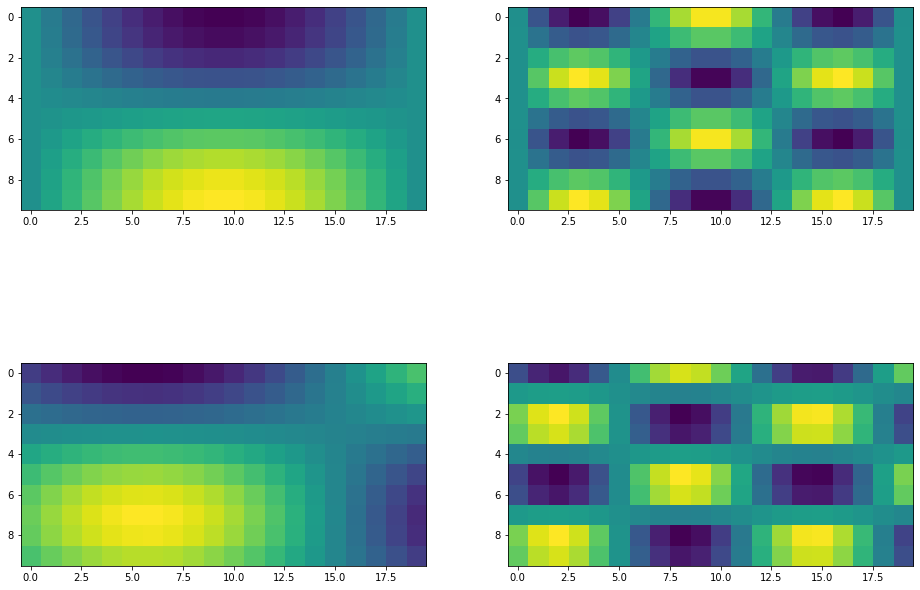

In [40]:
fg = plt.figure(figsize=(16,12))
axes = [plt.subplot(2,2,k+1) for k in range(4)]
#
with netCDF4.Dataset(output_file_path, 'r') as fin:
    #
    axes[0].imshow(fin.variables['U'][0,1,:,:])
    axes[1].imshow(fin.variables['U'][0,3,:,:])
    axes[2].imshow(fin.variables['U'][10,1,:,:])
    axes[3].imshow(fin.variables['U'][10,3,:,:])

##### Looks good. Now let's do some file create and write.

In [41]:
output_file_path_n4 = 'pretend_data_n4.nc'
my_lats = numpy.linspace(-90., 90, 10)
my_lons = numpy.linspace(-180., 180., 20)
my_elevs = numpy.arange(0, 10)*1000.
n_timesteps=100
my_time_steps = numpy.arange(0., n_timesteps)
#
if os.path.isfile(output_file_path_n4):
    os.system('rm {}'.format(output_file_path))
# do we need to delete the file?
with netCDF4.Dataset(output_file_path_n4, 'w') as fout:
    #
    # defne dimensions (note we can use the scritped syntax below):
    fout.createDimension('time', n_timesteps)
    fout.createDimension('alt', len(my_elevs))
    fout.createDimension('lat', len(my_lats))
    fout.createDimension('lon', len(my_lons))
    #
    # assign values to dimension variables (using list scripted syntax)
    #
    for s,x in zip(['time', 'alt', 'lat', 'lon'], [my_time_steps, my_elevs, my_lats, my_lons]):
        #print('** {} / {}'.format(s, fout.dimensions[s]))
        #
        # note: 1) we provide the dimension of the variable as a tuple
        #  2) 'f' is a small float, 'd' is a big float ("double"); trying to assign 'd' values
        #.  into a type 'f' variable may throw an error (as it does in this case)
        #fout.create_variable(s, 'f', (s,) )
        fout.createVariable(s, 'd', (s,) )
        fout.variables[s][:]=x[:]
        #print('** DEBUG: var[{}]: {}'.format(s, fout.variables[s]))
        print('** ** DEBUG: shape: ', numpy.shape(fout.variables[s]))
    #
    # Instantiate a data variable.
    # outf.create_variable('t','f',('time','lat','lon'))
    fout.createVariable('U','d',('time', 'alt', 'lat','lon'))
    setattr(fout.variables['U'], 'standard_name', 'pressure')
    setattr(fout.variables['U'], 'units', 'kPa')
    #
    print('** DEBUG: time: ', min(fout.variables['time']), max(fout.variables['time']))
    print('** DEBUG: lat: ', min(fout.variables['lat']), max(fout.variables['lat']))
    # variable assignment:
    # This syntax is required for scaler, non-indexed values (or so I have read):
    # fout.variables['u'].assign_value(udum)        # this works if dimensions align
    #. we can also use it for arrays, but only if we are assigning the whole value -- in other words, the 
    #. dimensinos must match. (this works if dim(udum)==dim(fout)). I assume the exception is if the output
    #. dimension is undefined, all other dimensions must match.
    #
    # For batched assignment, we can use:
    # fout.variables['u'][0:len(udum)] = udum      # use this for partial assignment (note, i think this does allow 
    #                                            # (aka, will expand) for overflow -- [k,j] > len(fout.variable) )
    #  if the dimenstions match, we can use this syntax without "slice" indices.
    #
    # and we might want to close the file here:
    print('file created: ')
    print(file_report(fout))
    #fout.close()
#

** ** DEBUG: shape:  (100,)
** ** DEBUG: shape:  (10,)
** ** DEBUG: shape:  (10,)
** ** DEBUG: shape:  (20,)
** DEBUG: time:  0.0 99.0
** DEBUG: lat:  -90.0 90.0
file created: 
** dims:  [('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 100
), ('alt', <class 'netCDF4._netCDF4.Dimension'>: name = 'alt', size = 10
), ('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 10
), ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 20
)]
** varnames_all:  odict_keys(['time', 'alt', 'lat', 'lon', 'U'])
** varnames:  ['U']
type(fin.dimensions):  <class 'collections.OrderedDict'>
None


In [43]:
# Assign some values:
# NOTE: we could have done this during the 'create' phase, but we want to demonstrate 
#. opening and closing.
with contextlib.closing(Nio.open_file(output_file_path_n4, 'r+')) as fout:
    #
    # if we just want to make our code work, we can do this:
    #fout.variables['U'] = numpy.random.random(size=list(fout.dimensions.values()))
    ##
    ## and even slightly differentiate the layers:
    ## add the index value to each altitude layer, so each layer is ~ 0+u, 1+u, 2+u, ...
    ##. (where u is a random number).
    #for k in range(0, fout.dimensions['alt']):
    #    fout.variables['U'][:,k,:,:] += k
    #
    # A more interesting example, fromm which we can make some pretty pictures:
    # compute some periodic constants:
    T_x = scipy.constants.pi/(max(fout.variables['lon']) - min(fout.variables['lon']))
    T_y = scipy.constants.pi/(max(fout.variables['lat']) - min(fout.variables['lat']))
    T_t = 2.*scipy.constants.pi/(max(fout.variables['time']) - min(fout.variables['time']))
    N_pi = numpy.arange(1, fout.dimensions['alt']+1,1)
    #
    # Populate the array:
    # For 2D arrays, we can use numpy.meshgrid(Xs, Ys) to get a dense n_x x n_y array, but
    #. I don't think there is a 2D abstraction. We want to avoid a fully nested loop, unless
    #. memory is a restriction.
    #
    XX, YY = numpy.array(numpy.meshgrid( fout.variables['lon'], fout.variables['lat']) )
    XX *= T_x
    YY *= T_y
    #
    # there's a faster, numpy way to do this (rebroadcast as cartesian dimensions), but I'm just going to
    #. get it done. (can you meshgrid() nested objects?
    #
    #print('*** shape:', numpy.shape(fout.variables['U']))
    #
    # we can probably do this more efficiently using numpy.outer(X,Y); we can nest numpy.outer()
    #. calls, and then reshpae(), xx = numpy.outer(X, numpy.outer(Y,Z)).reshape(len(X), len(Y), len(Z)))
    #
    #
    for (k_t, phi),k_z in itertools.product(enumerate(fout.variables['time']*T_t), N_pi):
        #
        #print('** ** ', k_t, phi, k_z)
        #zs = numpy.cos(k_z*XX + phi)*numpy.sin(k_z*YY + phi)
        #print('** DEBUG: zs: ', numpy.shape(zs))
        fout.variables['U'][k_t, k_z, :,:] = numpy.cos(k_z*XX + phi)*numpy.sin(k_z*YY + phi)
        
        #if k_z>5: break
#


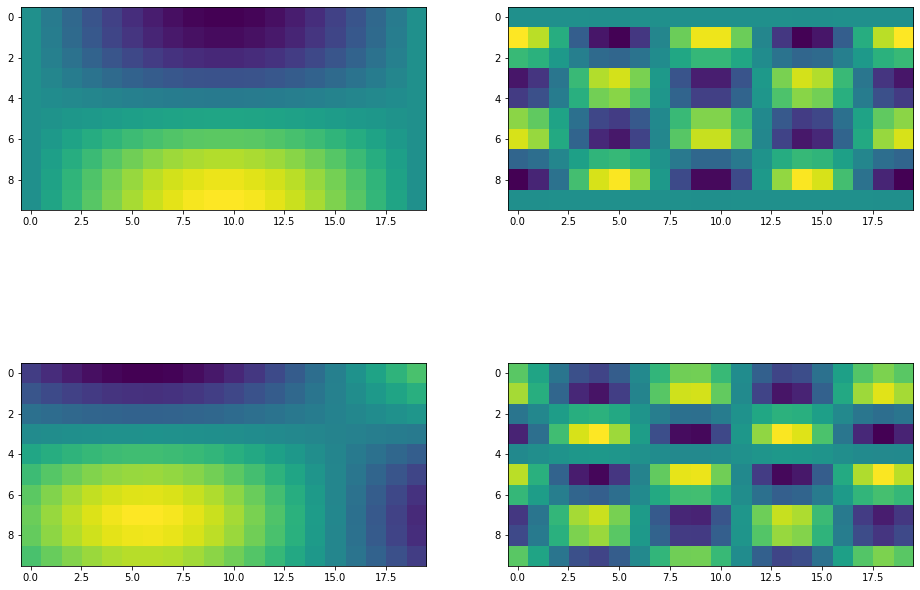

In [45]:
fg = plt.figure(figsize=(16,12))
axes = [plt.subplot(2,2,k+1) for k in range(4)]
#
with netCDF4.Dataset(output_file_path_n4, 'r') as fin:
    #
    axes[0].imshow(fin.variables['U'][0,1,:,:])
    axes[1].imshow(fin.variables['U'][0,4,:,:])
    axes[2].imshow(fin.variables['U'][10,1,:,:])
    axes[3].imshow(fin.variables['U'][10,4,:,:])